## Introduction

In this notebook we will use the Tensorflow Recommenders (TFRS) library to build a recommendation system. TFRS is a library for building deep learning recommendation systems. It helps with the full workflow of building a recommendation system: data preparation, model formulation, training, evaluation, and deployment. TFRS is built on top of TensorFlow 2 and Keras, and is designed to be scalable and easy to use.

We are first focusing on a retrieval system, which is a model that predicts a set of movies from the catalogue that the user is likely to watch. We're going to treat the dataset as an implicit system. This means that we are not trying to predict the rating that a user will give to a movie. Instead, we are trying to rank movies by their relevance to the user. This is a common scenario in many recommendation systems, where we are trying to predict the items that a user is most likely to interact with.
Treating Movielens as an implicit system means that we're interpreting users' actions (watching movies) as indicators of their preferences. Specifically:

1. Every movie a user has watched is considered a positive example, indicating that they like or are interested in that movie.
2. Every movie a user hasn't watched is treated as an implicit negative example, implying that they haven't shown interest in it or haven't been exposed to it yet.

This approach helps us make predictions about which movies users might enjoy based on their past behavior without requiring explicit feedback or ratings for each movie.

In a second step we will build a ranking model that predicts the top 10 movies that a user is likely to watch. This model will be trained on the same dataset as the retrieval model, but will be optimized for ranking accuracy rather than relevance.

## Imports

In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann

ERROR: Could not find a version that satisfies the requirement scann (from versions: none)
ERROR: No matching distribution found for scann


In [2]:
import os
import pprint
import tempfile
import pandas as pd

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

## Preprocessing

In [3]:
import tensorflow_datasets as tfds
import pandas as pd

# Load the datasets
ratings = tfds.load('movielens/100k-ratings', split='train')
movies = tfds.load('movielens/100k-movies', split='train')

# Function to convert tf.data.Dataset to pandas DataFrame
def tfds_to_pandas(dataset):
    # Initialize an empty list to store the data
    data = []
    # Iterate over the dataset
    for item in tfds.as_numpy(dataset):
        # Convert the tf.Tensor objects to numpy arrays and then to a dictionary
        data.append({key: item[key] for key in item})
    # Convert the list of dictionaries to a pandas DataFrame
    return pd.DataFrame(data)

# Convert the ratings and movies datasets to pandas DataFrames
ratings_df = tfds_to_pandas(ratings)
movies_df = tfds_to_pandas(movies)

# Display the first few rows of each DataFrame
ratings_df.head()

2024-05-01 10:32:20.457276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-01 10:32:22.032997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,[7],b'357',"b""One Flew Over the Cuckoo's Nest (1975)""",46.0,879024327,True,b'138',4,b'doctor',4.0,b'53211'
1,25.0,"[4, 14]",b'709',b'Strictly Ballroom (1992)',32.0,875654590,True,b'92',5,b'entertainment',2.0,b'80525'
2,18.0,[4],b'412',"b'Very Brady Sequel, A (1996)'",24.0,882075110,True,b'301',17,b'student',4.0,b'55439'
3,50.0,"[5, 7]",b'56',b'Pulp Fiction (1994)',50.0,883326919,True,b'60',4,b'healthcare',4.0,b'06472'
4,50.0,"[10, 16]",b'895',b'Scream 2 (1997)',55.0,891409199,True,b'197',18,b'technician',3.0,b'75094'


In [4]:
movies_df.head()

,movie_genres,movie_id,movie_title
0,[4],b'1681',b'You So Crazy (1994)'
1,"[4, 7]",b'1457',b'Love Is All There Is (1996)'
2,"[1, 3]",b'500',b'Fly Away Home (1996)'
3,[0],b'838',b'In the Line of Duty 2 (1987)'
4,[7],b'1648',"b'Niagara, Niagara (1997)'"


## Stratified Sampling

In [3]:
# transform pickle file to pandas dataframe
ratings_df = pd.read_pickle('data/df_ratings_cleaned.pkl')
movies_df = pd.read_pickle('data/df_movies_cleaned.pkl')

ratings_df.head()

,userId,movieId,rating,timestamp,user_mean_rating,liked_by_user
0,1,110,1.0,2015-03-09 22:52:09,4.277778,False
1,1,147,4.5,2015-03-09 23:07:15,4.277778,True
2,1,858,5.0,2015-03-09 22:52:03,4.277778,True
3,1,1221,5.0,2015-03-09 22:52:26,4.277778,True
4,1,1246,5.0,2015-03-09 22:52:36,4.277778,True


In [4]:
movies_df.head()

,id_x,movieId,imdbId,tmdbId,belongs_to_collection,original_language,overview,popularity,release_date,runtime,title,vote_average,vote_count,actors,keywords_extracted,genre_extracted,production_company_extracted,production_country_extracted
0,862,1,114709,862,1,en,"Led by Woody, Andy's toys live happily in his ...",21.0,1995-10-30,81.0,Toy Story,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[jealousy, toy, boy, friendship, friends, riva...","[Animation, Comedy, Family]",[Pixar Animation Studios],[United States of America]
1,8844,2,113497,8844,0,en,When siblings Judy and Peter discover an encha...,17.0,1995-12-15,104.0,Jumanji,6.9,2413.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]","[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America]
2,15602,3,113228,15602,1,en,A family wedding reignites the ancient feud be...,11.0,1995-12-22,101.0,Grumpier Old Men,6.5,92.0,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[fishing, best friend, duringcreditsstinger, o...","[Romance, Comedy]","[Warner Bros., Lancaster Gate]",[United States of America]
3,31357,4,114885,31357,0,en,"Cheated on, mistreated and stepped on, the wom...",3.0,1995-12-22,127.0,Waiting to Exhale,6.1,34.0,"[Whitney Houston, Angela Bassett, Loretta Devi...","[based on novel, interracial relationship, sin...","[Comedy, Drama, Romance]",[Twentieth Century Fox Film Corporation],[United States of America]
4,11862,5,113041,11862,1,en,Just when George Banks has recovered from his ...,8.0,1995-02-10,106.0,Father of the Bride Part II,5.7,173.0,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[baby, midlife crisis, confidence, aging, daug...",[Comedy],"[Sandollar Productions, Touchstone Pictures]",[United States of America]


In [5]:
# nr of entries in the dataset
ratings_df.shape

(24829828, 6)

In [6]:
movies_df.shape

(38862, 18)

We will use stratified sampling to downsample the ratings dataset to 100,000 entries. This will help us reduce the size of the dataset while maintaining the distribution of ratings. We will categorize the ratings into bins and sample an equal number of entries from each bin to ensure that the downsampled dataset is representative of the original dataset.

In [7]:
# We will use pandas' cut function to categorize these ratings
ratings_df['rating_category'] = pd.cut(ratings_df['rating'], bins=np.arange(0.5, 6.0, 0.5), include_lowest=True, right=False)

# Stratified sampling based on rating categories
strat_sampled_ratings_df = ratings_df.groupby('rating_category', group_keys=False).apply(
    lambda x: x.sample(int(np.rint(100000 * len(x) / len(ratings_df))), random_state=42)
)

print(f"Original DF Shape: {ratings_df.shape}")
print(f"Sampled DF Shape: {strat_sampled_ratings_df.shape}")
summary_stats_comparison(ratings_df, strat_sampled_ratings_df, 'rating')

/var/folders/08/34vp8sgn1vj1l_v1dzyhrdk00000gn/T/ipykernel_96769/2505950686.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  strat_sampled_ratings_df = ratings_df.groupby('rating_category', group_keys=False).apply(


Original DF Shape: (24829828, 7)
Sampled DF Shape: (100000, 7)


NameError: name 'summary_stats_comparison' is not defined

In [11]:
# Compare summary statistics of the original and downsampled datasets
def summary_stats_comparison(original_df, downsampled_df, column):
    """Compare summary statistics of a column in the original and downsampled datasets."""
    original_stats = original_df[column].describe()
    downsampled_stats = downsampled_df[column].describe()
    
    summary_stats = pd.concat([original_stats, downsampled_stats], axis=1)
    summary_stats.columns = ['Original', 'Sampled']
    
    return summary_stats

summary_stats_comparison(ratings_df, strat_sampled_ratings_df, 'rating')

,Original,Sampled
count,24829828.0,100000.0
mean,3.52898,3.52899
std,1.060177,1.060165
min,0.5,0.5
25%,3.0,3.0
50%,3.5,3.5
75%,4.0,4.0
max,5.0,5.0


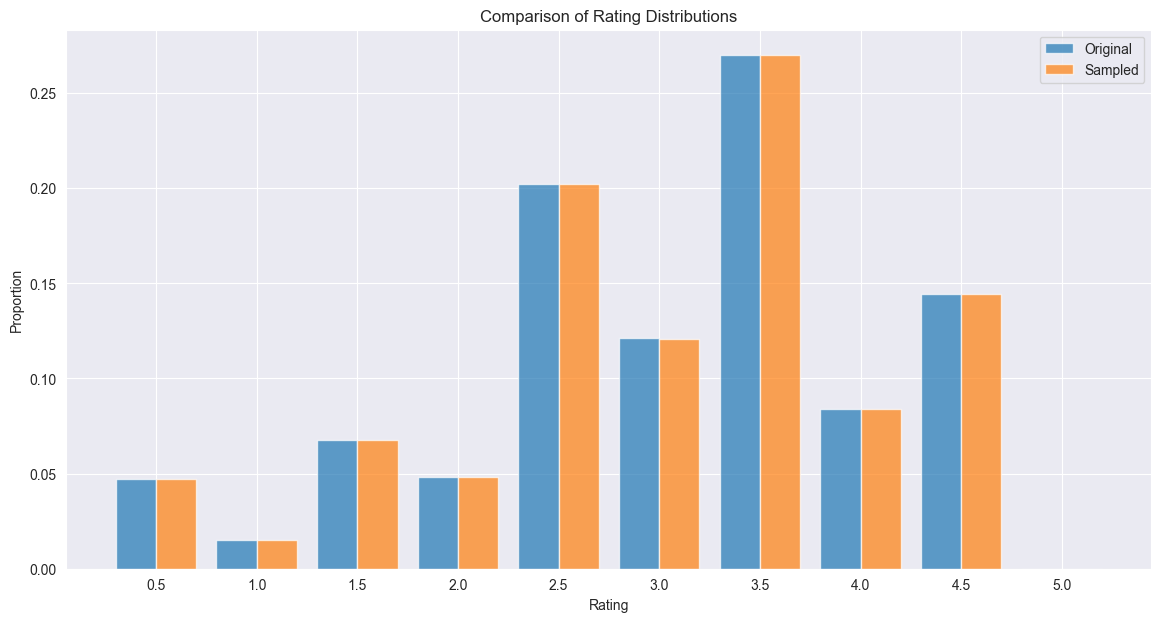

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Define your bins
bins = np.arange(0.5, 6.0, 0.5)

# Calculate bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Define width of each bar
bar_width = 0.2

# Plot histograms
plt.figure(figsize=(14, 7))
plt.bar(bin_centers - bar_width/2, ratings_df['rating'].value_counts(normalize=True, sort=False, bins=bins), width=bar_width, alpha=0.7, label='Original', align='center')
plt.bar(bin_centers + bar_width/2, strat_sampled_ratings_df['rating'].value_counts(normalize=True, sort=False, bins=bins), width=bar_width, alpha=0.7, label='Sampled', align='center')

plt.title('Comparison of Rating Distributions')
plt.xlabel('Rating')
plt.ylabel('Proportion')
plt.xticks(bin_centers, labels=[f"{bin:.1f}" for bin in bins[:-1]])  # Set x-tick labels to match bin centers
plt.legend()
plt.show()

In [9]:
strat_sampled_ratings_df

,userId,movieId,rating,timestamp,user_mean_rating,liked_by_user,rating_category
11800835,128365,1037,0.5,2009-10-19 10:10:37,3.104895,False,"[0.5, 1.0)"
3192182,34770,27316,0.5,2006-06-10 09:14:33,1.329146,False,"[0.5, 1.0)"
10041143,108700,307,0.5,2010-05-12 21:26:12,3.729651,False,"[0.5, 1.0)"
14911364,162680,73929,0.5,2015-11-22 18:22:29,3.505618,False,"[0.5, 1.0)"
13024846,141941,4308,0.5,2006-06-10 05:21:47,2.987685,False,"[0.5, 1.0)"
...,...,...,...,...,...,...,...
2596165,28184,2912,5.0,2000-11-21 00:08:40,3.588011,True,"[5.0, 5.5)"
2174721,23629,1185,5.0,1997-03-13 18:00:11,3.734463,True,"[5.0, 5.5)"
23363519,254448,49272,5.0,2016-08-08 15:59:55,3.819149,True,"[5.0, 5.5)"
19688576,214494,541,5.0,2005-04-05 14:26:59,3.395652,True,"[5.0, 5.5)"


In [10]:
# Save the downsampled dataset to a pickle file
strat_sampled_ratings_df.to_pickle('data/df_ratings_100k.pkl')

## Adjust Datasets for TFRS Requirements

In [12]:
# Show column types
strat_sampled_ratings_df.dtypes

userId                       int64
movieId                      int64
rating                     Float64
timestamp           datetime64[ns]
user_mean_rating           Float64
liked_by_user              boolean
rating_category           category
dtype: object

In [30]:
ratings_df_tfrs.dtypes

bucketized_user_age      float32
movie_genres              object
movie_id                  object
movie_title               object
raw_user_age             float32
timestamp                  int64
user_gender                 bool
user_id                   object
user_occupation_label      int64
user_occupation_text      object
user_rating              float32
user_zip_code             object
dtype: object

In [31]:
ratings_df_tfrs.head()

,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,[7],b'357',"b""One Flew Over the Cuckoo's Nest (1975)""",46.0,879024327,True,b'138',4,b'doctor',4.0,b'53211'
1,25.0,"[4, 14]",b'709',b'Strictly Ballroom (1992)',32.0,875654590,True,b'92',5,b'entertainment',2.0,b'80525'
2,18.0,[4],b'412',"b'Very Brady Sequel, A (1996)'",24.0,882075110,True,b'301',17,b'student',4.0,b'55439'
3,50.0,"[5, 7]",b'56',b'Pulp Fiction (1994)',50.0,883326919,True,b'60',4,b'healthcare',4.0,b'06472'
4,50.0,"[10, 16]",b'895',b'Scream 2 (1997)',55.0,891409199,True,b'197',18,b'technician',3.0,b'75094'


In [13]:
# Drop rating_category column that was created for downsampling
strat_sampled_ratings_df.drop(columns=['rating_category'], inplace=True)

In [14]:
import pandas as pd

# First, ensure movieId and userId are converted to strings (object dtype in pandas)
strat_sampled_ratings_df['movieId'] = strat_sampled_ratings_df['movieId'].astype(str)
strat_sampled_ratings_df['userId'] = strat_sampled_ratings_df['userId'].astype(str)

# Convert 'rating', 'user_mean_rating' to float32 for memory efficiency and compatibility
float_columns = ['rating', 'user_mean_rating']
for col in float_columns:
    strat_sampled_ratings_df[col] = strat_sampled_ratings_df[col].astype('float32')

# Convert 'timestamp' from datetime64[ns] to int64 (UNIX timestamp)
strat_sampled_ratings_df['timestamp'] = strat_sampled_ratings_df['timestamp'].astype('int64') // 10**9

# Ensure 'liked_by_user' is a int (1 or 0)
strat_sampled_ratings_df['liked_by_user'] = strat_sampled_ratings_df['liked_by_user'].astype('int')

# Print data types to verify
strat_sampled_ratings_df.dtypes

userId               object
movieId              object
rating              float32
timestamp             int64
user_mean_rating    float32
liked_by_user         int64
dtype: object

In [15]:
strat_sampled_ratings_df

,userId,movieId,rating,timestamp,user_mean_rating,liked_by_user
11800835,128365,1037,0.5,1255947037,3.104895,0
3192182,34770,27316,0.5,1149930873,1.329146,0
10041143,108700,307,0.5,1273699572,3.729651,0
14911364,162680,73929,0.5,1448216549,3.505618,0
13024846,141941,4308,0.5,1149916907,2.987685,0
...,...,...,...,...,...,...
2596165,28184,2912,5.0,974765320,3.588012,1
2174721,23629,1185,5.0,858276011,3.734463,1
23363519,254448,49272,5.0,1470671995,3.819149,1
19688576,214494,541,5.0,1112711219,3.395652,1


In [18]:
import tensorflow as tf

def df_to_dataset(dataframe, shuffle=True, batch_size=32, label_column=None):
    """
    Converts a DataFrame to a tf.data.Dataset.

    Args:
    dataframe (pd.DataFrame): The pandas DataFrame to convert.
    shuffle (bool): Whether to shuffle the data.
    batch_size (int): Batch size for the dataset.
    label_column (str, optional): The name of the label column, if any.

    Returns:
    tf.data.Dataset: The resulting TensorFlow Dataset.
    """
    dataframe = dataframe.copy()
    if label_column is not None:
        labels = dataframe.pop(label_column)
        dataset = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    else:
        dataset = tf.data.Dataset.from_tensor_slices(dict(dataframe))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))
    dataset = dataset.batch(batch_size)
    return dataset

In [22]:
# Convert the DataFrame to a TensorFlow Dataset
ratings = df_to_dataset(strat_sampled_ratings_df, batch_size=2)

In [24]:
for x in ratings.take(1):
    pprint.pprint(x)

{'liked_by_user': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 1])>,
 'movieId': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'969', b'170'], dtype=object)>,
 'rating': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([3. , 3.5], dtype=float32)>,
 'timestamp': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([ 859444645, 1105437019])>,
 'userId': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'214555', b'148244'], dtype=object)>,
 'user_mean_rating': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([3.4963503, 3.282967 ], dtype=float32)>}


2024-05-01 11:35:11.845852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


For the TFRS we will use the movielens dataset from [Tensorflow](https://www.tensorflow.org/datasets/catalog/movielens) which is specifically designed to work with TFRS. It is equal to the dataset that was used for the Preprocessing and EDA. However, we will use a subset dataset that is able to run.

- 100k-ratings: This dataset contains 100,000 ratings from 943 users on 1,682 movies. This dataset is the oldest version of the MovieLens dataset.
- 100k-movies: This dataset contains data of 1,682 movies rated in the 100k dataset.

In [22]:
# Ratings data.
ratings_tfrs = tfds.load("movielens/100k-ratings", split="train")

#Movie Data
movies_tfrs = tfds.load("movielens/100k-movies", split="train")

In [45]:
# Transform the dataset to a pandas dataframe
ratings_df_tfrs = tfds.as_dataframe(ratings_tfrs)

2024-05-01 10:58:20.256334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [46]:
ratings_df_tfrs.head()

,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,[7],b'357',"b""One Flew Over the Cuckoo's Nest (1975)""",46.0,879024327,True,b'138',4,b'doctor',4.0,b'53211'
1,25.0,"[4, 14]",b'709',b'Strictly Ballroom (1992)',32.0,875654590,True,b'92',5,b'entertainment',2.0,b'80525'
2,18.0,[4],b'412',"b'Very Brady Sequel, A (1996)'",24.0,882075110,True,b'301',17,b'student',4.0,b'55439'
3,50.0,"[5, 7]",b'56',b'Pulp Fiction (1994)',50.0,883326919,True,b'60',4,b'healthcare',4.0,b'06472'
4,50.0,"[10, 16]",b'895',b'Scream 2 (1997)',55.0,891409199,True,b'197',18,b'technician',3.0,b'75094'


In [19]:
ratings_df_tfrs.shape

(100000, 12)

In [44]:
for x in ratings_tfrs.take(1).as_numpy_iterator():
  pprint.pprint(x)

{'bucketized_user_age': 45.0,
 'movie_genres': array([7]),
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'raw_user_age': 46.0,
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4.0,
 'user_zip_code': b'53211'}


2024-05-01 10:57:49.383298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
for x in movies.take(1).as_numpy_iterator():
  pprint.pprint(x)

{'movie_genres': array([4]),
 'movie_id': b'1681',
 'movie_title': b'You So Crazy (1994)'}


2024-04-29 17:53:06.715090: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-29 17:53:06.715368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In this Notebook we only going to focus on the ratings dataset. We keep only the user_id, and movie_title fields in the dataset.

In [6]:
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
})
movies = movies.map(lambda x: x["movie_title"])

In [25]:
# Set the random seed for reproducibility
tf.random.set_seed(42)

# Shuffle the dataset with a specified buffer size and seed
shuffled = ratings.shuffle(buffer_size=100_000, seed=42, reshuffle_each_iteration=False)

# Take the first 80,000 examples for the training set (80% of the data)
train_dataset = shuffled.take(80_000)

# Skip the first 80,000 examples and take the next 20,000 for the test set (20% of the data)
test_dataset = shuffled.skip(80_000).take(20_000)

Lets investigate the unique user ids and movie titles in the dataset.

In [30]:
# Unique user ids and movie titles
user_ids_vocabulary = ratings.batch(1_000_000).map(lambda x: x["userId"])
#movie_titles_vocabulary = ratings.batch(1_000_000).map(lambda x: x[""])

#unique_movie_titles = np.unique(np.concatenate(list(movie_titles_vocabulary)))
unique_user_ids = np.unique(np.concatenate(list(user_ids_vocabulary)))

unique_user_ids[:10]

2024-05-01 11:42:24.523717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


array([b'100004', b'10002', b'100021', b'100022', b'100029', b'100031',
       b'100037', b'100038', b'100044', b'100046'], dtype=object)


The extraction and identification of unique user IDs and movie titles from a dataset are crucial for efficiently managing and processing data in machine learning applications, especially in recommender systems. By converting these categorical labels into unique numerical identifiers, we can optimize memory usage and enhance computational efficiency, which is fundamental for training accurate and scalable models. This preprocessing step also ensures that each entity (user or movie) is uniquely represented, aiding in the precise construction of user-item interaction matrices that are essential for personalization and prediction accuracy in recommendation algorithms.

## Model

We will build a two-tower retrieval model using the TFRS library. This model consists of two separate components or "towers".

A two-tower retrieval model is a type of architecture commonly used in recommendation systems, particularly in the context of information retrieval tasks such as recommending items to users. The "two towers" refer to two separate components or "towers" within the model:

Query Tower: This tower represents the user's query or input. It typically takes user-specific information or features, such as user demographics, past interactions, or explicit preferences, and encodes them into a fixed-length representation.
Candidate Tower: This tower represents the items in the catalog or database that are being considered for recommendation. It takes item-specific information or features, such as item attributes, metadata, or embeddings, and encodes them into a fixed-length representation.
After encoding both the query and candidate items, the model computes a similarity score between them.